In [ ]:
!pip install qiskit

In [ ]:
import numpy as np
import scipy 

import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit import algorithms
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.opflow import I, X, Y, Z
from qiskit.quantum_info.operators import Operator
from qiskit.algorithms.optimizers import SPSA

from qiskit import IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager

In [ ]:
#IBMQ.save_account('0d47bc90b8025d37a742d61f4ae4282997e76a2ec2c189eeb5258405eb651f2fb894e88cfcf817ffce43eb8b796de6006cc6c39a987384467b4c8866bd5e6877')
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>]

In [ ]:
def circuit(num_qubits, num_layers):
  varform = QuantumCircuit(num_qubits)

  t = Parameter('t')
  alpha = ParameterVector('alpha', num_layers)
  beta = ParameterVector('beta', num_layers)
  gamma = ParameterVector('gamma', num_layers)

  #rowsize = (num_qubits**2-num_qubits)//2
  rowsize = num_qubits - 1
  delta = ParameterVector('delta', num_layers * rowsize)
  eps = ParameterVector('eps', num_layers * rowsize)
  kappa = ParameterVector('kappa', num_layers * rowsize)
  
  for n in range(num_layers):
    for k in range(num_qubits):
      varform.rx(2*alpha[n]*t, k)
    for k in range(num_qubits):
      varform.ry(2*beta[n]*t, k)
    for k in range(num_qubits):
      varform.rz(2*gamma[n]*t, k)

    ## 2-body interactions
    for p in range(num_qubits):
      for q in range(num_qubits):
        c = 0
        if p < q:
          #varform.rxx(2*delta[n + rowsize*c]*t, p, q)
          varform.rxx(2*delta[n*rowsize + abs(p-q)-1]*t, p, q)
          c += 1

    for p in range(num_qubits):
      for q in range(num_qubits):
        c = 0
        if p < q:
          #varform.ryy(2*eps[n + rowsize*c]*t, p, q)
          varform.ryy(2*eps[n*rowsize + abs(p-q)-1]*t, p, q)
          c += 1

    for p in range(num_qubits):
      for q in range(num_qubits):
        c = 0
        if p < q:
          #varform.rzz(2*kappa[n + rowsize*c]*t, p, q)
          varform.rzz(2*kappa[n*rowsize + abs(p-q)-1]*t, p, q)
          c += 1
    varform.barrier()

  return varform, t


In [ ]:
varform, time_param = circuit(num_qubits=4, num_layers=2)

In [ ]:
varform.draw()

┌──────────────────┐┌─────────────────┐┌──────────────────┐»
q_0: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     ├──────────────────┤├─────────────────┤├──────────────────┤»
q_1: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     ├──────────────────┤├─────────────────┤├──────────────────┤»
q_2: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     ├──────────────────┤├─────────────────┤├──────────────────┤»
q_3: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     └──────────────────┘└─────────────────┘└──────────────────┘»
«     ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«q_0: ┤0                   ├┤0                   ├┤0                   ├»
«     │  Rxx(2*delta[0]*t) ││                    ││                    │»
«q_1: ┤1                   ├┤  Rxx(2*delta[1]*t) ├┤                    ├»
«     └────────────────────┘│                    ││  Rxx(2*delta[2]*t) │»
«q_2: ──────────────────────┤1                   ├┤                    ├»
«                           └────────────────────┘│                    │»
«q_3: ────────────────────────────────────────────┤1                   ├»
«                                                 └────────────────────┘»
«                                                  ┌──────────────────┐ »
«q_0: ─────────────────────────────────────────────┤0                 ├─»
«     ┌────────────────────┐┌────────────────────┐ │  Ryy(2*eps[0]*t) │ »
«q_1: ┤0                   ├┤0                   ├─┤1                 ├─»
«     │  Rxx(2*delta[0]*t) ││                    │┌┴──────────────────┴┐»
«q_2: ┤1                   ├┤  Rxx(2*delta[1]*t) ├┤0                   ├»
«     └────────────────────┘│                    ││  Rxx(2*delta[0]*t) │»
«q_3: ──────────────────────┤1                   ├┤1                   ├»
«                           └────────────────────┘└────────────────────┘»
«     ┌──────────────────┐┌──────────────────┐                    »
«q_0: ┤0                 ├┤0                 ├────────────────────»
«     │                  ││                  │┌──────────────────┐»
«q_1: ┤  Ryy(2*eps[1]*t) ├┤                  ├┤0                 ├»
«     │                  ││  Ryy(2*eps[2]*t) ││  Ryy(2*eps[0]*t) │»
«q_2: ┤1                 ├┤                  ├┤1                 ├»
«     └──────────────────┘│                  │└──────────────────┘»
«q_3: ────────────────────┤1                 ├────────────────────»
«                         └──────────────────┘                    »
«                                                                »
«q_0: ─────────────────────■───────────────────■─────────────────»
«     ┌──────────────────┐ │ZZ(2*kappa[0]*t)   │                 »
«q_1: ┤0                 ├─■───────────────────┼─────────────────»
«     │                  │┌──────────────────┐ │ZZ(2*kappa[1]*t) »
«q_2: ┤  Ryy(2*eps[1]*t) ├┤0                 ├─■─────────────────»
«     │                  ││  Ryy(2*eps[0]*t) │                   »
«q_3: ┤1                 ├┤1                 ├───────────────────»
«     └──────────────────┘└──────────────────┘                   »
«                                                              »
«q_0: ─■───────────────────────────────────────────────────────»
«      │                                                       »
«q_1: ─┼──────────────────■──────────────────■─────────────────»
«      │                  │ZZ(2*kappa[0]*t)  │                 »
«q_2: ─┼──────────────────■──────────────────┼─────────────────»
«      │ZZ(2*kappa[2]*t)                     │ZZ(2*kappa[1]*t) »
«q_3: ─■─────────────────────────────────────■─────────────────»
«                                                              »
«                         ░ ┌──────────────────┐┌─────────────────┐»
«q_0: ────────────────────░─┤ Rx(2*alpha[1]*t) ├┤ Ry(2*beta[1]*t) ├»
«                         ░ ├──────────────────┤├─────────────────┤»
«q_1: ────────────────────░─┤ Rx(2*alpha[1]*t) ├┤ Ry(2*beta[1]*t) ├»
«  

In [ ]:
num_params = varform.num_parameters
print(num_params)
print(varform.parameters)

25
ParameterView([ParameterVectorElement(alpha[0]), ParameterVectorElement(alpha[1]), ParameterVectorElement(beta[0]), ParameterVectorElement(beta[1]), ParameterVectorElement(delta[0]), ParameterVectorElement(delta[1]), ParameterVectorElement(delta[2]), ParameterVectorElement(delta[3]), ParameterVectorElement(delta[4]), ParameterVectorElement(delta[5]), ParameterVectorElement(eps[0]), ParameterVectorElement(eps[1]), ParameterVectorElement(eps[2]), ParameterVectorElement(eps[3]), ParameterVectorElement(eps[4]), ParameterVectorElement(eps[5]), ParameterVectorElement(gamma[0]), ParameterVectorElement(gamma[1]), ParameterVectorElement(kappa[0]), ParameterVectorElement(kappa[1]), ParameterVectorElement(kappa[2]), ParameterVectorElement(kappa[3]), ParameterVectorElement(kappa[4]), ParameterVectorElement(kappa[5]), Parameter(t)])


In [ ]:
def exact_hamiltonian(num_qubits):
  def pair_coupling_matrix():
    J = np.zeros(shape=(num_qubits, num_qubits))
    for p in range(num_qubits):
      for q in range(num_qubits):
        J[p,q] = 1 - np.cos(np.arccos(0.9)*(np.abs(p-q)/(num_qubits-1)))
    return J

  def sigma_k(k):
    sigma_X = ( (I^k) ^ X ^ (I^(num_qubits-k-1)) ).to_matrix()
    sigma_Y = ( (I^k) ^ Y ^ (I^(num_qubits-k-1)) ).to_matrix()
    sigma_Z = ( (I^k) ^ Z ^ (I^(num_qubits-k-1)) ).to_matrix()
    return np.array([sigma_X, sigma_Y, sigma_Z])

  dim = 2**num_qubits

  b_vector = np.array([np.sqrt(1.0-0.925**2), 0.0, -0.925])
  sigma_vectors = [sigma_k(qubit) for qubit in range(num_qubits)] # num_qubits x 3 x (dim x dim)
  J = pair_coupling_matrix()

  first_term = np.zeros(shape=(dim,dim), dtype=np.complex128)
  for i in range(num_qubits):
    sigma_vec_mul = (b_vector[:, None, None] * sigma_vectors[i])
    first_term += np.sum(sigma_vec_mul, axis=0)

  second_term = np.zeros(shape=(dim,dim), dtype=np.complex128)
  for p in range(num_qubits):
    for q in range(num_qubits):
      if p < q:
        for pauli_idx in range(3):
          second_term += J[p,q] * (sigma_vectors[p][pauli_idx] @ sigma_vectors[q][pauli_idx])

  return first_term + second_term  

In [ ]:
def exact_unitaries(num_qubits, ts):
  H = exact_hamiltonian(num_qubits)
  operators = []
  for t in ts:
    U = scipy.linalg.expm(-1j * t * H)
    operators.append(Operator(U))
    #print(operators[-1].is_unitary())
  return operators

def exact_states(num_qubits, ts , init_state=None):
  init_state = init_state or Statevector.from_label('0'*num_qubits)

  unitaries = exact_unitaries(num_qubits, ts)

  output_states = [init_state.evolve(U) for U in unitaries]
  return output_states

# ts = np.linspace(0,2*np.pi,4)
# exact_states(2, ts)

In [ ]:
def optimize_simulation(varform, time_param, num_time_marks:int):

  def cost_fn(x):
    full_circuits = [circ.bind_parameters(x) for circ in bind_circuits]

    circuit_states = [init_state.evolve(full_circ) for full_circ in full_circuits]


    tomo_circ_sets = []
    for full_circ in full_circuits:
      # every full_circ produces 3^n tomo circuits
      tomo_circ_sets += state_tomography_circuits(full_circ, full_circ.qubits)
    
    job_results = job_manager.run(tomo_circ_sets, backend=backend, shots=512).results()
    tomo_job_results = [job_results[i:i + tomo_size] for i in range(0, len(job_results), tomo_size)]

    tomo_states = []
    for idx,res in enumerate(tomo_job_results):
      tomo_fitter_bell = StateTomographyFitter(res, tomo_circ_sets[idx*tomo_size : (idx+1)*tomo_size])
      rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
      tomo_states.append()

    job = qiskit.execute(qst, backend, shots=512)
    tomo_fitter_bell = StateTomographyFitter(job.result(), qst)
    rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
    #   tomo_states.append(rho_fit_bell)
    # tomo_states = []
    # for circ in bind_circuits:
    #   binded_circ = circ.bind_parameters(x)
    #   qst = state_tomography_circuits(binded_circ, binded_circ.qubits)
    #   job = qiskit.execute(qst, Aer.get_backend('qasm_simulator'), shots=512)
    #   tomo_fitter_bell = StateTomographyFitter(job.result(), qst)
    #   rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
    #   tomo_states.append(rho_fit_bell)


    
    device_fids = []
    for i in range(len(circuit_states)):
      device_fids.append(state_fidelity(circuit_states[i], tomo_states[i]))
    sum_device_fid = sum(device_fids)

    fids = []
    for i in range(len(circuit_states)):
      fids.append(state_fidelity(circuit_states[i], ideal_states[i]))
    sum_fid = sum(fids)

    #regularizer = np.linalg.norm(x)**2 / (2*np.pi)**2
    #lambd = 0.1
    print(sum_fid, sum_device_fid)
    return -sum_fid / len(circuit_states) #+ (lambd/len(x))*regularizer


  provider = IBMQ.load_account()
  backend = provider.get_backend('ibmq_qasm_simulator')
  job_manager = IBMQJobManager()
  tomo_size = 3**varform.num_qubits

  start = 0.
  end = 1.
  ts = np.linspace(end,start,num_time_marks, endpoint=False)[::-1]
  print(ts)
  bind_circuits = [varform.bind_parameters({time_param: t}) for t in ts]
  init_state = Statevector.from_label('0'*varform.num_qubits)

  ideal_states = exact_states(varform.num_qubits, ts, init_state)

  init_params = np.random.rand(varform.num_parameters-1)
  options = {'maxiter':100, 'disp':True}
  res = scipy.optimize.minimize(cost_fn, x0=init_params, method='BFGS', options=options)
  return res.x, res.fun

  # init_params = np.random.rand(varform.num_parameters-1)
  # opt = SPSA(maxiter=5000)
  # point, value, nfev = opt.optimize(num_vars=varform.num_parameters-1, objective_function=cost_fn,initial_point= init_params)
  # return point, value


In [ ]:
param_opt, value_opt = optimize_simulation(varform, time_param, 2)

[0.5 1. ]
0.4768403268048814 1.9801506683472148
0.47684031584102393 1.9791660689776913
0.4768403284809803 1.9826031191369426
0.4768403278713793 1.9743103137918547
0.47684030727756344 1.979403275848829
0.47684032785701363 1.9783331719951267
0.476840323865908 1.972828993488192
0.4768403199359148 1.984121554004939
0.47684032469890564 1.9755638408886806
0.47684032325588105 1.984112407992829
0.47684032322240477 1.9757268410685636
0.4768403308160665 1.9846621899492158
0.47684033486052124 1.9861298307393125
0.47684032911058083 1.9847460268253108
0.4768403338981722 1.9806845495398266
0.4768403328247883 1.9821982133347915
0.4768403309473022 1.9810183345915373
0.4768403355427096 1.9737288555679933
0.47684032410497085 1.98455226190487
0.47684032231478407 1.9756896878510481
0.47684032361826123 1.9829324131682635
0.47684031994398907 1.9760863269838964
0.4768403225062768 1.9809417680751258
0.47684032764692824 1.9780933888695174
0.4768403271771835 1.9798133566777376
0.7948875756171478 1.9808036954561

KeyboardInterrupt: ignored

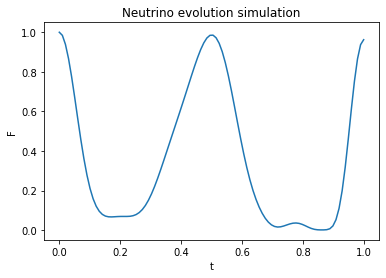

In [ ]:
import matplotlib.pyplot as plt

def simulation(varform, param):
  init_state = Statevector.from_label('0'*varform.num_qubits)
  ts = np.linspace(0,1,100)
  exact_output_states = exact_states(varform.num_qubits, ts, init_state)

  bind_circuits = [varform.bind_parameters({time_param: t}) for t in ts]
  output_states = [init_state.evolve(circ.bind_parameters(param)) for circ in bind_circuits]

  fids = []
  for i in range(len(output_states)):
    fids.append(state_fidelity(output_states[i], exact_output_states[i]))

  plt.plot(ts, fids, label='Fidelity')
  plt.xlabel('t')
  plt.ylabel('F')
  #plt.ylim(0,1.1)
  plt.title('Neutrino evolution simulation')

simulation(varform, param_opt)  

In [ ]:
PauliX = np.array([[0.0, 1.0], [1.0, 0.0]])
PauliY = np.array([[0.0, -1.0j], [1.0j, 0.0]])
PauliZ = np.array([[1.0, 0.0], [-1.0, 0.0]])
b_vector = np.array([np.sqrt(1.0-0.925**2), 0.0, -0.925])
sigma_0  = [np.kron(np.kron(np.kron(PauliX,I),I),I), np.kron(np.kron(np.kron(PauliY,I),I),I), np.kron(np.kron(np.kron(PauliZ,I),I),I)]
sigma_1  = [np.kron(np.kron(np.kron(I,PauliX),I),I), np.kron(np.kron(np.kron(I,PauliY),I),I), np.kron(np.kron(np.kron(I,PauliZ),I),I)]
sigma_2  = [np.kron(np.kron(np.kron(I,I),PauliX),I), np.kron(np.kron(np.kron(I,I),PauliY),I), np.kron(np.kron(np.kron(I,I),PauliZ),I)]
sigma_3  = [np.kron(np.kron(np.kron(I,I),I),PauliX), np.kron(np.kron(np.kron(I,I),I),PauliY), np.kron(np.kron(np.kron(I,I),I),PauliZ)]
sigma = [sigma_0, sigma_1, sigma_2, sigma_3]
def jpq(p,q, N):
    return 1 - np.cos(np.arccos(0.9)*(np.abs(p-q)/(N-1)))

ValueError: ignored

In [ ]:
def neutrino_Hamiltonian(nums_of_neu):
    first_term = np.array([[0.0 + 0.0j]*16]*16)
    second_term = np.array([[0.0 + 0.0j]*16]*16)
    for i in range(nums_of_neu):
        for j in range(len(b_vector)):
            first_term += b_vector[j]*sigma[i][j]
    for i in range(nums_of_neu):
        for j in range(i+1, nums_of_neu):
            for k in range(len(sigma[j])):
                second_term += jpq(i,j,nums_of_neu)*np.matmul(sigma[i][k],sigma[j][k])
    return first_term